# **Data Analysis Exercise**
### *EU procurement contract networks (2008-2016)*

Steve Kerr

211924

# Setup

## Load packages

In [1]:
%%capture
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [2]:
%%capture
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [3]:
import graph_tool.all as gt
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

## Load data

In [4]:
country_list = ['NO', 'PT', 'SK'] # Norway, Portugal, & Slovakia
year_list = range(2010, 2017, 2) # 2010 & 2012, 2014, 2016

# Create an empty dictionary to store networks
networks = {}

# Iterate over each country and year to import networks
for country in country_list:

  for year in year_list:

    network_title = f'{country}_{year}'
    networks[network_title] = gt.collection.ns[f'eu_procurements_alt/{network_title}']

In [5]:
# Inspect networks
networks

{'NO_2010': <Graph object, undirected, with 2265 vertices and 2673 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0cd2fe80>,
 'NO_2012': <Graph object, undirected, with 2318 vertices and 2782 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0aa3b790>,
 'NO_2014': <Graph object, undirected, with 2256 vertices and 2678 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0aa3b9d0>,
 'NO_2016': <Graph object, undirected, with 2851 vertices and 3627 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0cd2fee0>,
 'PT_2010': <Graph object, undirected, with 1382 vertices and 1378 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0a88cbb0>,
 'PT_2012': <Graph object, undirected, with 1175 vertices and 1123 edges, 2 internal vertex pro

## Create projections from bipartite network

In [6]:
# Initialize an empty dictionary to store networkx graphs
networks_nx = {}

for network, g_tool_graph in networks.items():

    # Initialize a new networkx graph for the current dataset
    g_nx = nx.Graph()

    # Add vertices and corresponding properties to the networkx graph
    for v in g_tool_graph.vertices():

        # Here, 'v_prop' is a dictionary of the vertex properties
        v_prop = {prop: g_tool_graph.vp[prop][v] for prop in g_tool_graph.vertex_properties.keys()}
        g_nx.add_node(v, **v_prop)

    # Add edges and corresponding properties to the networkx graph
    for e in g_tool_graph.edges():

        # Here, 'e_prop' is a dictionary of the edge properties
        e_prop = {prop: g_tool_graph.ep[prop][e] for prop in g_tool_graph.edge_properties.keys()}
        g_nx.add_edge(e.source(), e.target(), **e_prop)

    # Append the networkx graph to our dictionary
    networks_nx[network] = g_nx

In [7]:
# Initialize empty dictionary to store projections
networks_proj = {}

# Function to create and return both issuer and winner projections from a bipartite graph
def create_projections(g):

    issuers_set = {n for n, d in g.nodes(data=True) if d['label'].endswith('_i')}
    winners_set = {n for n, d in g.nodes(data=True) if d['label'].endswith('_w')}

    # Create the bipartite projections
    issuer_proj = nx.algorithms.bipartite.projected_graph(g, issuers_set)
    winner_proj = nx.algorithms.bipartite.projected_graph(g, winners_set)

    return issuer_proj, winner_proj

# Function to convert a networkx graph to a graph-tool graph
def convert_networkx_to_graphtool(g_nx, name_description):

    g_gt = gt.Graph(directed=False)
    pos_property = g_gt.new_vertex_property("vector<double>")
    label_property = g_gt.new_vertex_property("string")
    vertex_map = {node: g_gt.add_vertex() for node in g_nx}

    for node, data in g_nx.nodes(data=True):

        v = vertex_map[node]
        pos_property[v] = data.get('_pos', [0.0, 0.0])
        label_property[v] = data['label']

    for u, v in g_nx.edges():

        g_gt.add_edge(vertex_map[u], vertex_map[v])

    # Set the graph name and description properties
    g_gt.graph_properties["name"] = g_gt.new_graph_property("string", name_description[0])
    g_gt.graph_properties["description"] = g_gt.new_graph_property("string", name_description[1])

    return g_gt, pos_property, label_property

# Loop over each network in datasets_nx
for dataset_key, g_nx in networks_nx.items():

    # Split the key to get country and year
    country, year = dataset_key.split('_')

    # Create the projections
    issuer_proj, winner_proj = create_projections(g_nx)

    # Convert projections to graph-tool format
    name_description = (f"eu_procurements_alt ({country}_{year}_issuer)",
                        "Issuer projection of the bipartite graph")

    networks_proj[f"{country}_{year}_issuer"], _, _ = convert_networkx_to_graphtool(issuer_proj, name_description)

    name_description = (f"eu_procurements_alt ({country}_{year}_winner)",
                        "Winner projection of the bipartite graph")

    networks_proj[f"{country}_{year}_winner"], _, _ = convert_networkx_to_graphtool(winner_proj, name_description)

# Separate projections by winners and issuers
winners_proj = {network_title: g for network_title, g in networks_proj.items() if network_title.endswith('_winner')}
issuers_proj = {network_title: g for network_title, g in networks_proj.items() if network_title.endswith('_issuer')}


# Overall network properties


In [8]:
networks['NO_2010']

<Graph object, undirected, with 2265 vertices and 2673 edges, 2 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x7e4c0cd2fe80>

In [9]:
networks['NO_2010'].list_properties()

name             (graph)   (type: string, val: eu_procurements_alt (NO_2010))
description      (graph)   (type: string, val: These 234 networks represent the
                                               annual national public
                                               procurement markets of 26
                                               European countries from
                                               2008-2016, inclusive. Data is
                                               sourced from Tenders Electronic
                                               Daily (TED), the official
                                               procurement portal of the
                                               European Union.  Nodes with the
                                               suffix "_i" are issuers
                                               (sometimes referred to as
                                               buyers) of public contracts, for
                       

## Degree distribution

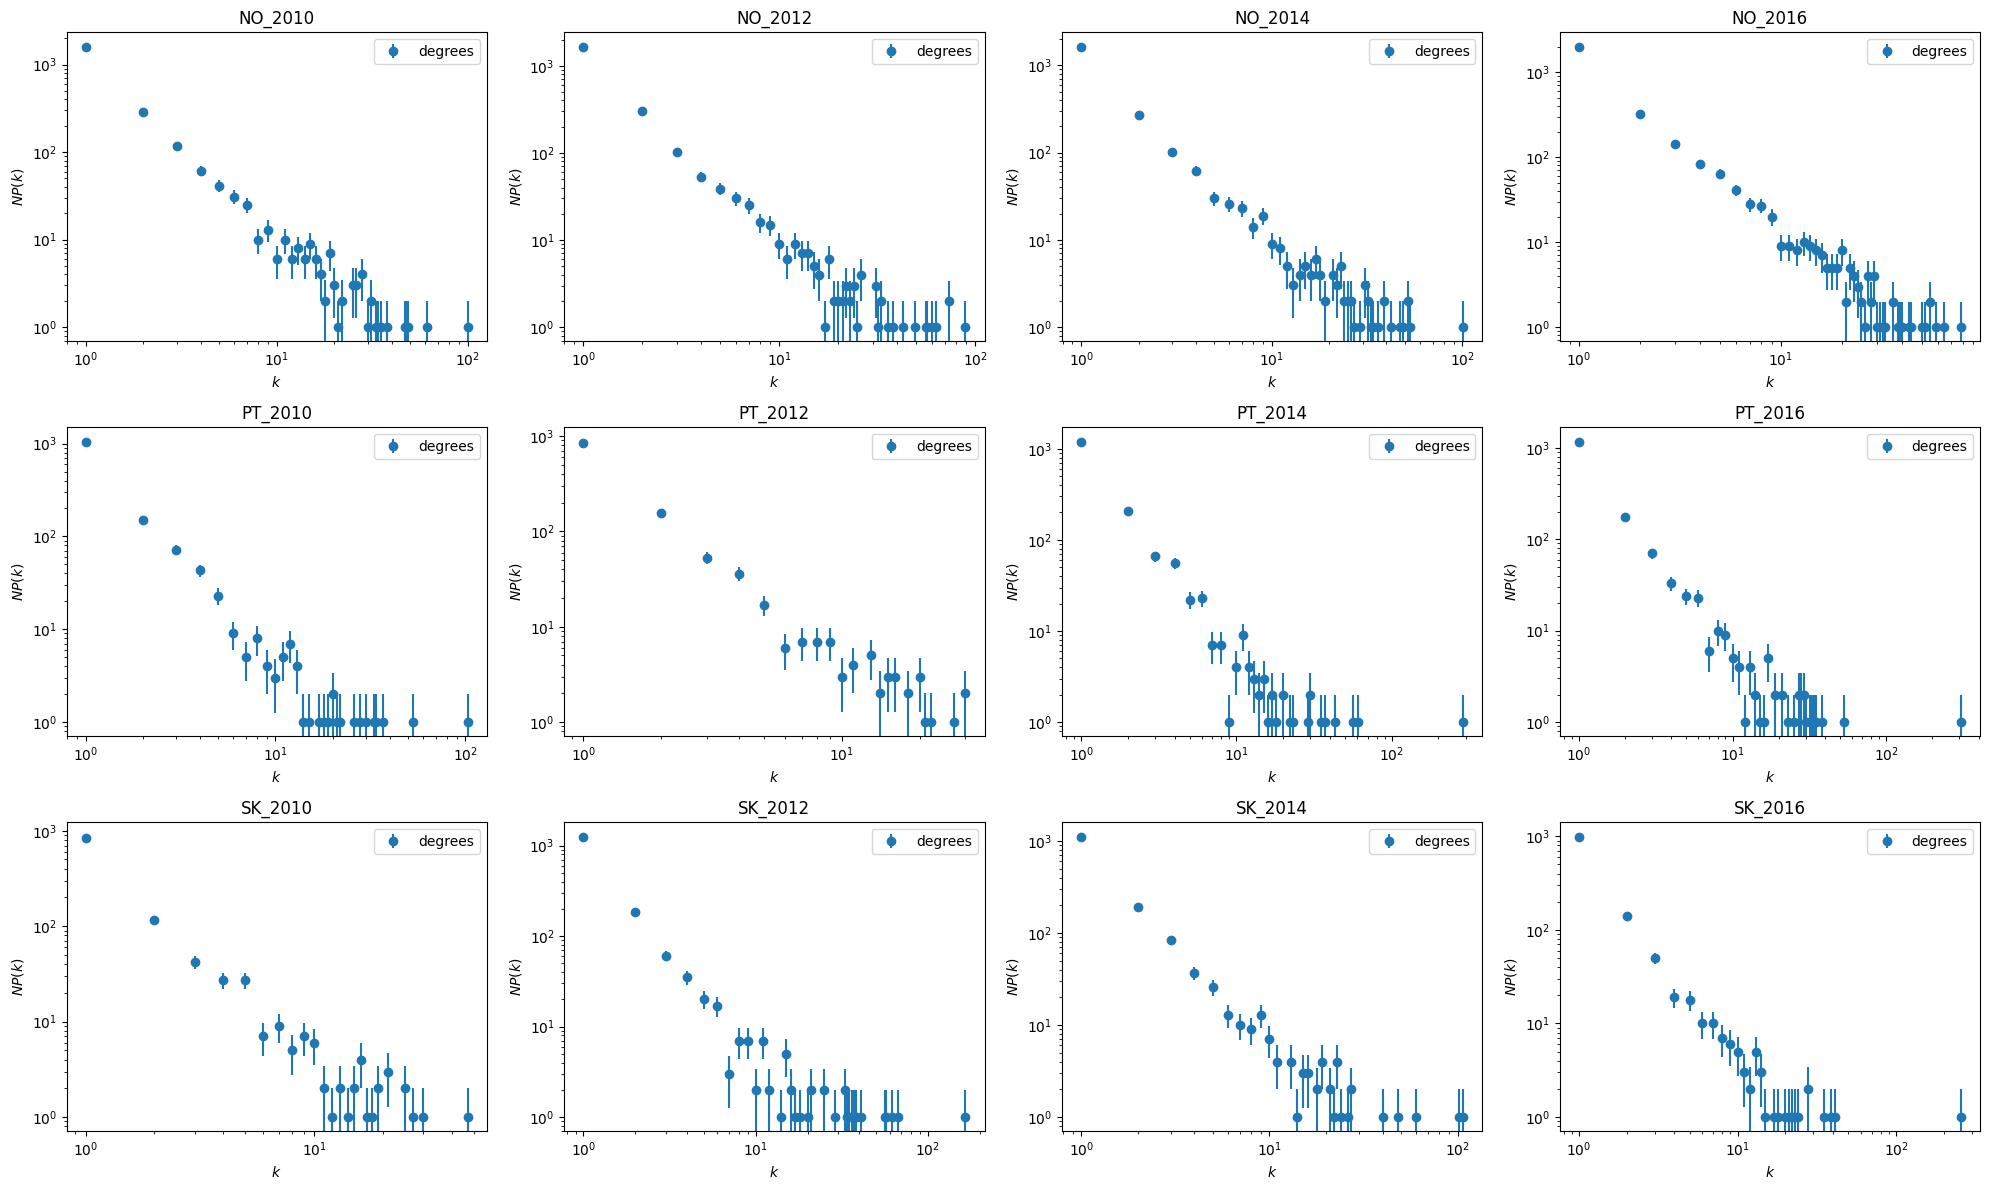

In [10]:
# TODO: Add power law distribution ---------------------------------------------

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=((20, 12)))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and create plots
for i, (network_title, g) in enumerate(networks.items()):

    ax = axes[i]
    hist = gt.vertex_hist(g, "total")
    y = hist[0]
    err = np.sqrt(hist[0])
    ax.errorbar(hist[1][:-1], y, fmt="o", yerr=err, label="degrees")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("$k$")
    ax.set_ylabel("$NP(k)$")
    ax.set_title(network_title)
    ax.legend()

plt.tight_layout()
plt.show()

## Layouts

In [11]:
# Function to draw a graph-tool graph using the edge properties 'count' and 'pctSingleBid'. Here, 'count' is the number of contracts
# between two nodes and 'pctSingleBid' is the percentage of contracts between two nodes that were single-bid contracts. 'count' is used
# as weight for the edge pen width and 'pctSingleBid' is used to color the edges where the edges become more red as the percentage of
# single-bid contracts increases, i.e. goes from 0 to 1. The vertex color is determined by the vertex type, i.e. 'issuer' or 'winner'.
# The vertex type is determined by the vertex label, which ends with '_i' for issuers and '_w' for winners. The vertex outline is black
# for all vertices. The vertex pen width is set to 1.2. The function returns a dictionary with the drawing parameters.

def draw_weighted_colored_graph(u, edge_color_property_name='edge_color'):
    """
    Prepares edge color, pen width, and vertex color based on 'count', 'pctSingleBid',
    and vertex type ('issuer' or 'winner').
    Designed to be used within gt.graph_draw.
    :param u: The graph for which the drawing parameters are being prepared.
    :param edge_color_property_name: The name to be assigned to the new edge color property.
    :return: A dictionary with the edge_color, edge_pen_width, vertex_fill_color, and vertex_outline properties.
    """
    # Retrieve the 'count' and 'pctSingleBid' edge properties
    edge_count = u.ep["count"]
    edge_pctSingleBid = u.ep["pctSingleBid"]

    # Create a new edge property for the matplotlib color mapping
    edge_color = u.new_edge_property('vector<double>')
    u.ep[edge_color_property_name] = edge_color

    # Create color maps and normalization instance for edges
    cmap = plt.get_cmap('coolwarm')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)  # 'pctSingleBid' is between 0 and 1

    # Assign colors to edges based on 'pctSingleBid' values
    for e in u.edges():
        normalized_value = norm(edge_pctSingleBid[e])
        edge_color[e] = cmap(normalized_value)

    # Prepare vertex color properties
    vertex_fill_color = u.new_vertex_property('vector<double>')
    vertex_outline = u.new_vertex_property('vector<double>')  # For the boundary

    # Check the vertex 'label' property and assign colors accordingly
    for v in u.vertices():
        label = u.vp.label[v]
        if label.endswith("_i"):  # Check if the vertex label ends with '_i'
            vertex_fill_color[v] = [0.5, 0.5, 0.5, 1]  # White for issuers
        elif label.endswith("_w"):  # Check if the vertex label ends with '_w'
            vertex_fill_color[v] = [1, 1, 1, 1]  # Gray for winners
        vertex_outline[v] = [0, 0, 0, 1]  # Black outline for all vertices

    # Prepare the dictionary with drawing parameters
    drawing_parameters = {
        'edge_color': edge_color,
        'edge_pen_width': gt.prop_to_size(edge_count, mi=0.5, ma=25, power=1),
        'vertex_fill_color': vertex_fill_color,
        'vertex_color': vertex_outline,  # This is for the boundary
        'vertex_pen_width': 1.2  # Adjust the pen width as needed
    }

    return drawing_parameters

### Default layout

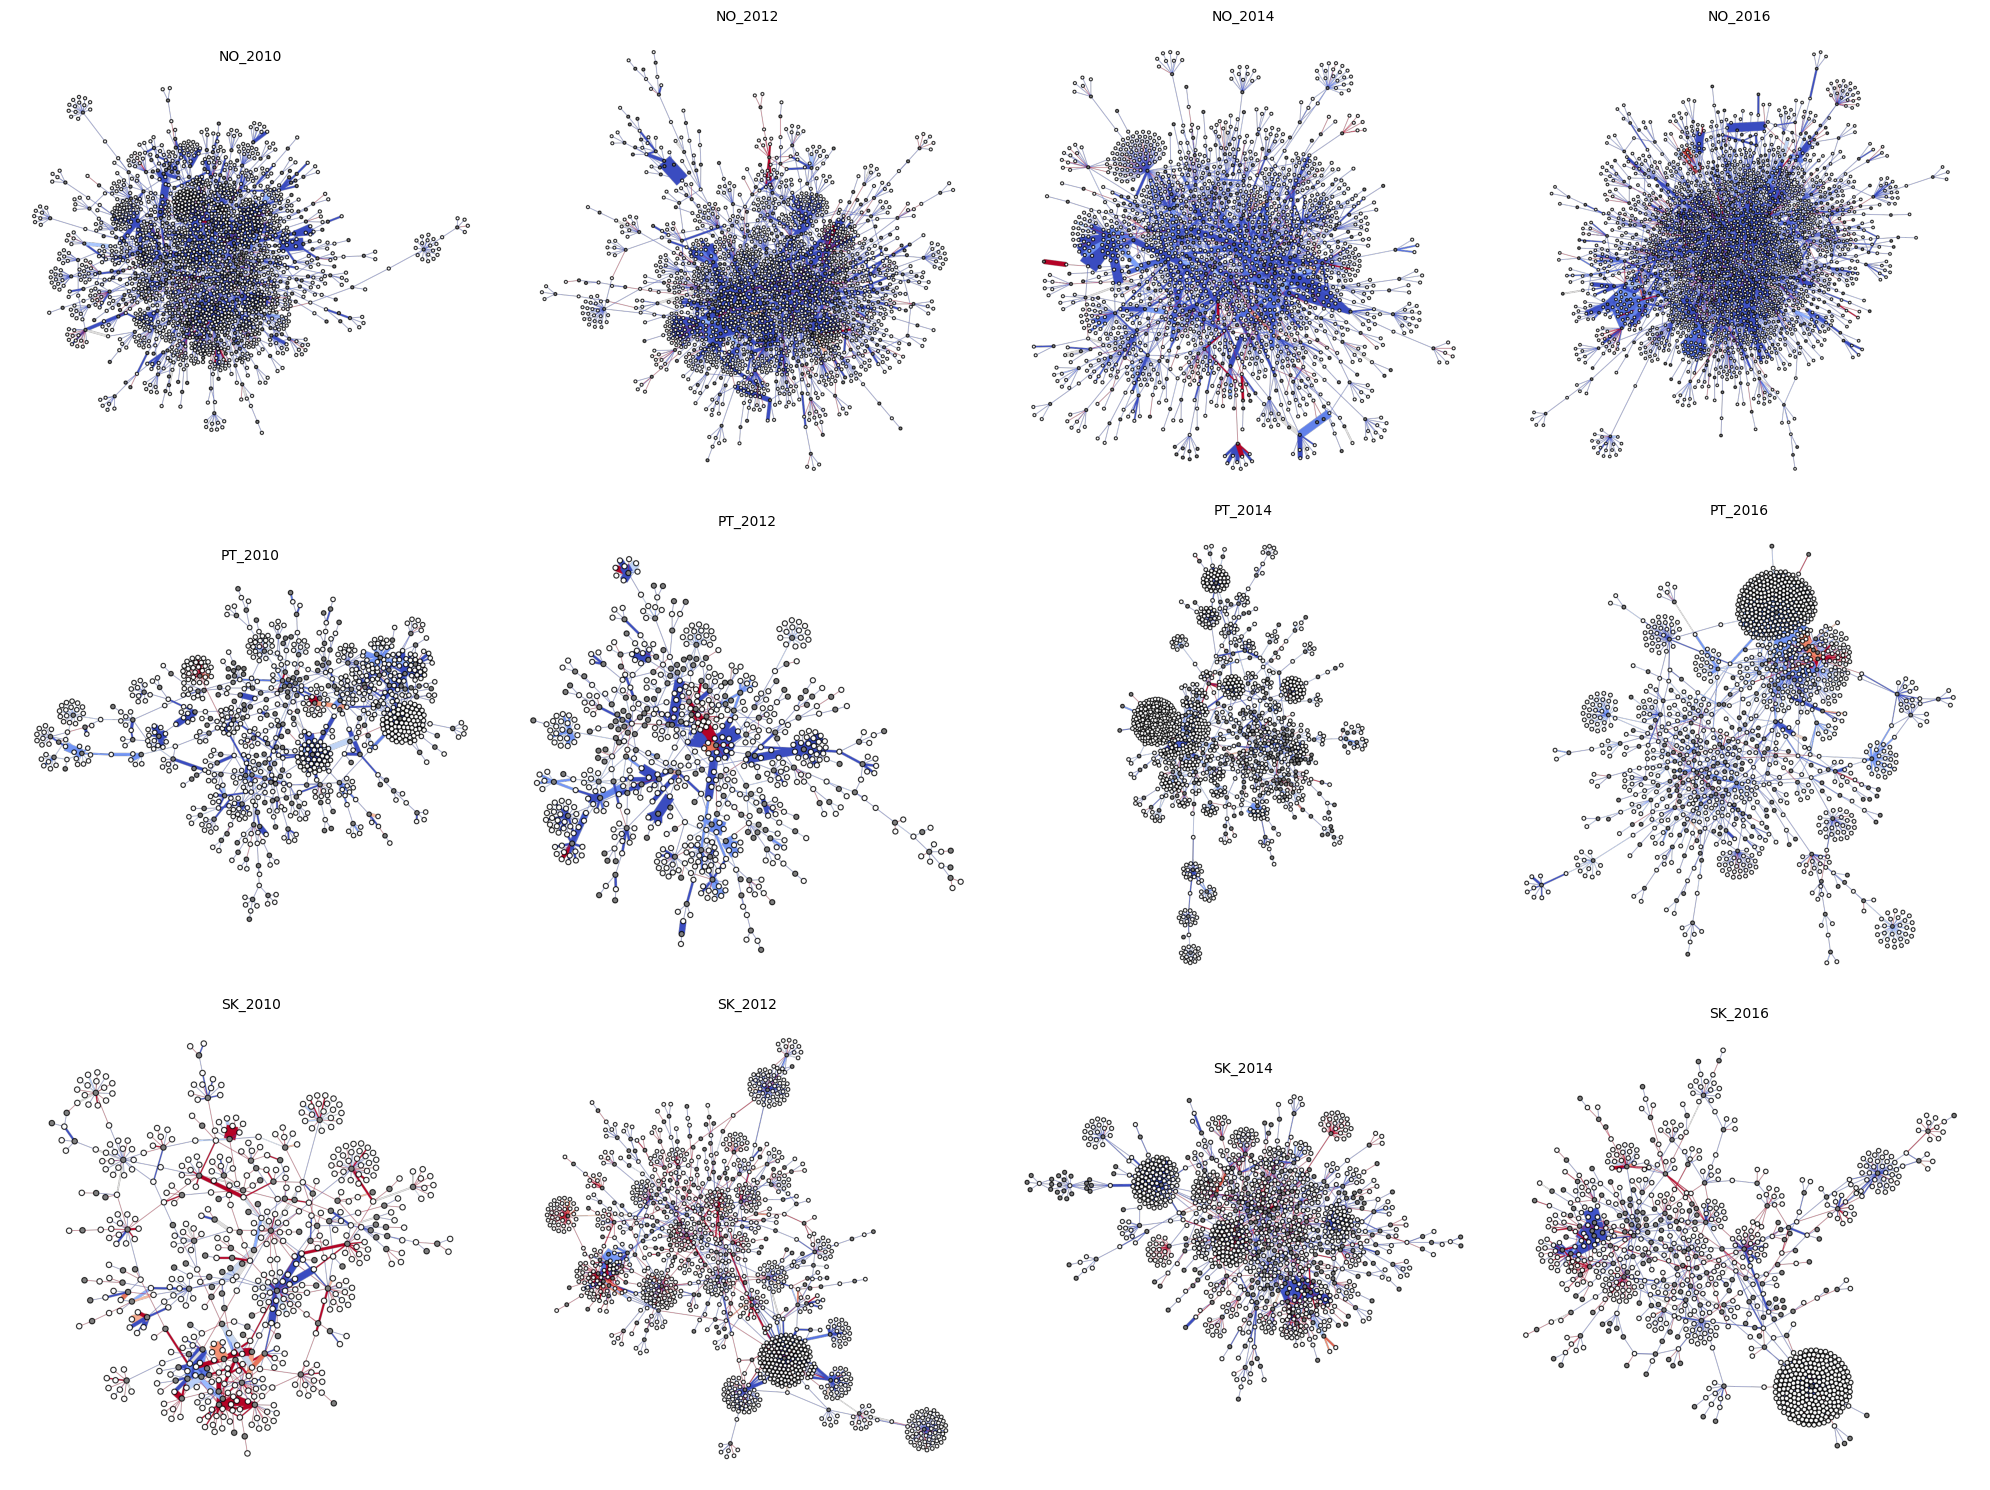

In [12]:
# Ensure the output directory exists for the stored positions
output_dir_vp = "default_layout"
os.makedirs(output_dir_vp, exist_ok=True)

# Loop through each dataset and save the graph using the stored positions as an image
for network_title, g in networks.items():
    u = gt.extract_largest_component(g, prune=True)
    output_path = os.path.join(output_dir_vp, f"{network_title}.png")
    drawing_parameters = draw_weighted_colored_graph(u)
    gt.graph_draw(u, pos=u.vp["_pos"], output=output_path,**drawing_parameters)

# Get the list of all saved images for the stored positions
image_files_vp = sorted([os.path.join(output_dir_vp, f) for f in os.listdir(output_dir_vp) if f.endswith('.png')])

# Create the figure with subplots for the stored positions
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for the stored positions and add it to the subplot
for i, image_file in enumerate(image_files_vp):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes

    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

### Spring layout

IndexError: ignored

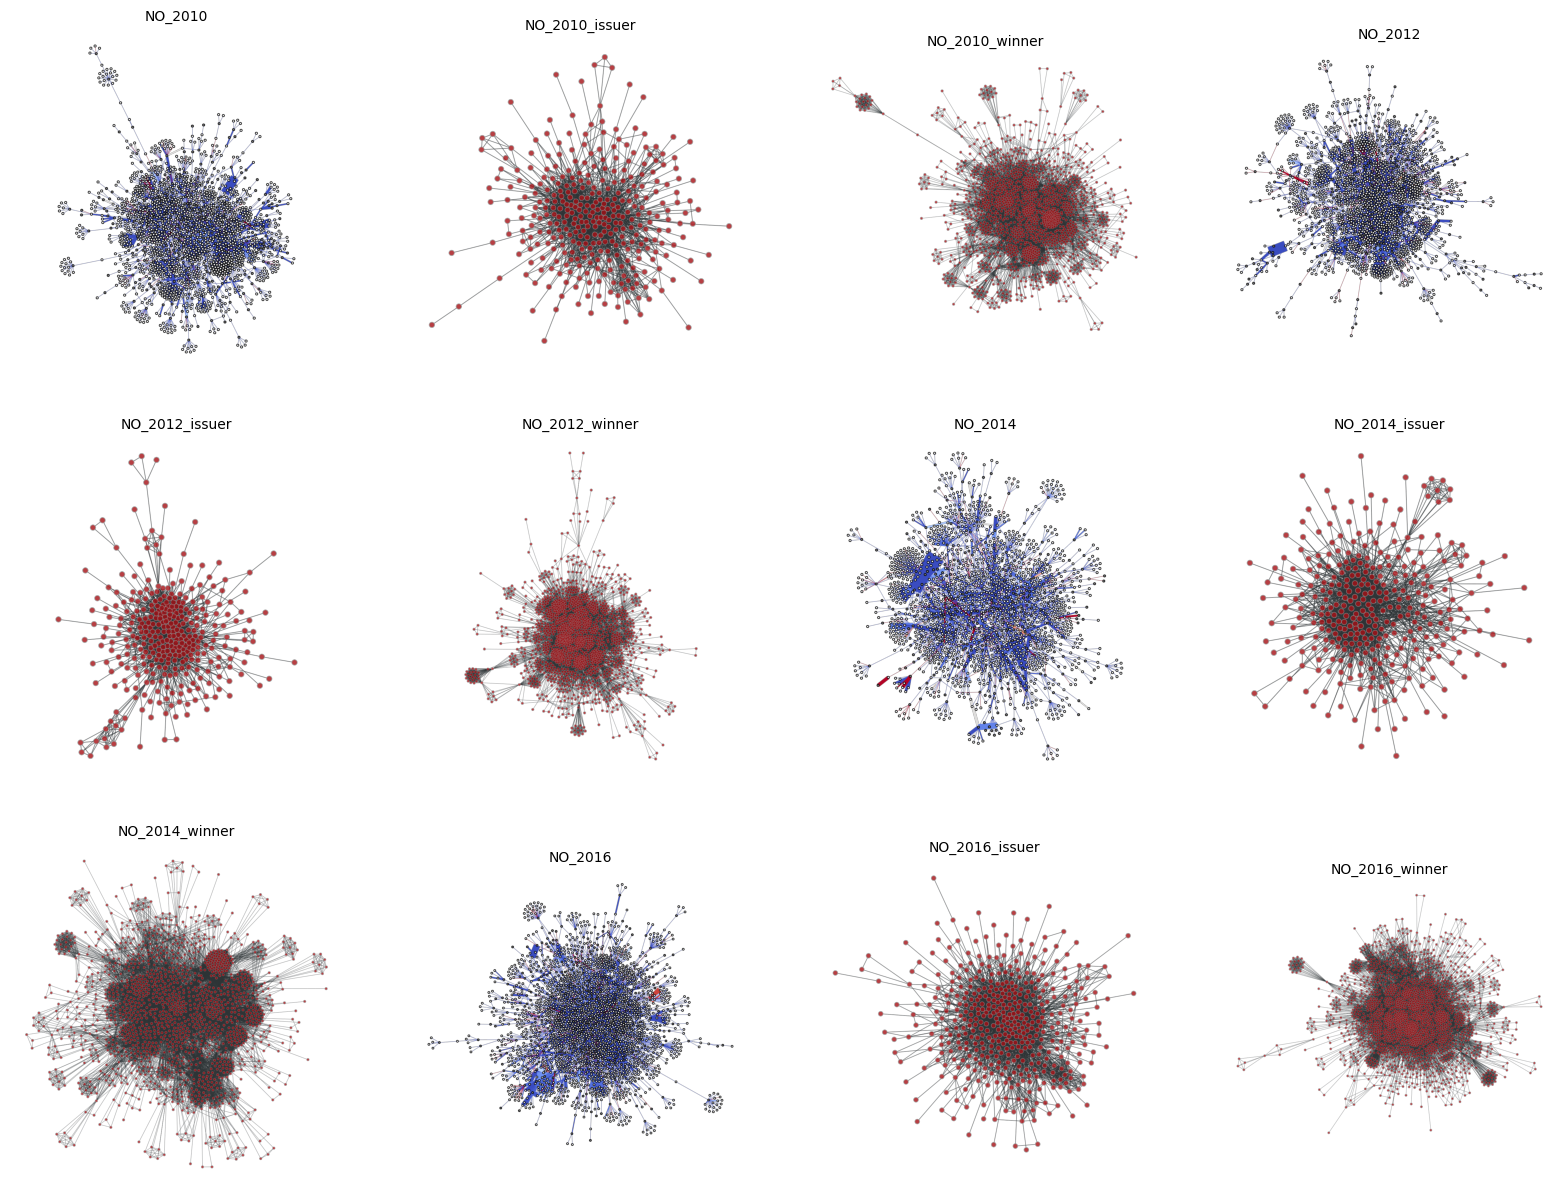

In [13]:
# Ensure the output directory exists
output_dir = "sfdp_layout"
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and save the graph as an image
for network_title, g in networks.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u)
    output_path = os.path.join(output_dir, f"{network_title}.png")
    drawing_parameters = draw_weighted_colored_graph(u)
    gt.graph_draw(u, pos, output=output_path, **drawing_parameters)


# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Create the figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis

    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Fruchterman-Reingold layout

In [ ]:
# Ensure the output directory exists for Fruchterman-Reingold layouts
output_dir_fr = "fr_layout"
os.makedirs(output_dir_fr, exist_ok=True)

# Loop through each dataset and save the graph with Fruchterman-Reingold layout as an image
for network_title, g in networks.items():
    u = gt.extract_largest_component(g, prune=True)
    pos_fr = gt.fruchterman_reingold_layout(u, n_iter=100)  # Set the number of iterations if needed
    output_path = os.path.join(output_dir_fr, f"{network_title}.png")
    drawing_parameters = draw_weighted_colored_graph(u)
    gt.graph_draw(u, pos_fr, output=output_path, **drawing_parameters)

# Get the list of all saved images for Fruchterman-Reingold layouts
image_files_fr = sorted([os.path.join(output_dir_fr, f) for f in os.listdir(output_dir_fr) if f.endswith('.png')])

# Create the figure with subplots for Fruchterman-Reingold layouts
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for Fruchterman-Reingold layouts and add it to the subplot
for i, image_file in enumerate(image_files_fr):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes

    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

# Projected network properties

In [ ]:
# Use Norway, 2010 as a test case ----------------------------------------------
g_i = issuers_proj['NO_2010_issuer']
g_w = winners_proj['NO_2010_winner']

In [ ]:
networks_proj['NO_2010_issuer'], networks_proj['NO_2010_winner']

## Degree distribution

In [ ]:
# Calculate the maximum degree (number of edges) in the graph 'u'
maximum_i = max(u_i.get_total_degrees(u_i.get_vertices()))

# Print the indices of vertices with the maximum degree.
# This will identify the vertices with the highest number of edges.
print(np.where(u_i.get_total_degrees(u_i.get_vertices()) == maximum_i))

# Print the degrees of all vertices in the graph.
print(u_i.get_total_degrees(u_i.get_vertices()))

In [ ]:
# Calculate the maximum degree (number of edges) in the graph 'u'
maximum_w = max(u_w.get_total_degrees(u_w.get_vertices()))

# Print the indices of vertices with the maximum degree.
# This will identify the vertices with the highest number of edges.
print(np.where(u_w.get_total_degrees(u_w.get_vertices()) == maximum_w))

# Print the degrees of all vertices in the graph.
print(u_w.get_total_degrees(u_w.get_vertices()))

In [ ]:
# Power Law Distribution -------------------------------------------------------

# # Parameters for the power-law distribution
# alpha = 5  # Power-law exponent
# xmin = 1  # Minimum value

# data = g_i.get_total_degrees(g_i.get_vertices())

# # Create a histogram of the data
# hist, bin_edges = np.histogram(data, density=True)

# # Calculate the midpoints of the bins for x values
# x = (bin_edges[1:] + bin_edges[:-1]) / 2

# # Plot the data with logged x and y axes
# plt.figure(figsize=(8, 6))
# plt.plot(x, hist, 'o', markersize=4, label='Data')

# # Plot the power-law distribution
# x_fit = np.logspace(np.log10(min(data)), np.log10(max(data)), 100)
# y_fit = (alpha - 1) * xmin ** (alpha - 1) * x_fit ** (-alpha)
# plt.plot(x_fit, y_fit, label=f'Power Law (alpha={alpha})', color='red')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Log X-axis')
# plt.ylabel('Log Y-axis')
# plt.title('Power Law Distribution')
# plt.legend()
# plt.grid(True)

# plt.show()

In [ ]:
# TODO: Add power law distribution ---------------------------------------------

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=((20, 12)))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and create plots
for i, (network_title, g) in enumerate(issuers_proj.items()):

    ax = axes[i]
    hist = gt.vertex_hist(g, "total")
    y = hist[0]
    err = np.sqrt(hist[0])
    ax.errorbar(hist[1][:-1], y, fmt="o", yerr=err, label="degrees")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("$k$")
    ax.set_ylabel("$NP(k)$")
    ax.set_title(network_title)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# TODO: Add power law distribution ---------------------------------------------

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=((20, 12)))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each dataset and create plots
for i, (network_title, g) in enumerate(winners_proj.items()):

    ax = axes[i]
    hist = gt.vertex_hist(g, "total")
    y = hist[0]
    err = np.sqrt(hist[0])
    ax.errorbar(hist[1][:-1], y, fmt="o", yerr=err, label="degrees")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("$k$")
    ax.set_ylabel("$NP(k)$")
    ax.set_title(network_title)
    ax.legend()

plt.tight_layout()
plt.show()

## Diameters

The pseudo-diameter is an approximate graph diameter. It is obtained by starting from a vertex source, and finds a vertex target that is farthest away from source. This process is repeated by treating target as the new starting vertex, and ends when the graph distance no longer increases. A vertex from the last level set that has the smallest degree is chosen as the final starting vertex u, and a traversal is done to see if the graph distance can be increased. This graph distance is taken to be the pseudo-diameter.

The paths are computed with a breadth-first search (BFS) or Dijkstra’s algorithm [dijkstra], if weights are given.

https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.topology.pseudo_diameter.html#graph_tool.topology.pseudo_diameter

In [ ]:
for network_title, g in issuers_proj.items():
  g = networks_proj[network_title]
  u = gt.extract_largest_component(g, prune=True)
  dist, ends = gt.pseudo_diameter(u)
  print(network_title, dist)

In [ ]:
for network_title, g in winners_proj.items():
  g = networks_proj[network_title]
  u = gt.extract_largest_component(g, prune=True)
  dist, ends = gt.pseudo_diameter(u)
  print(network_title, dist)

## Shortest distance

In [ ]:
dist = gt.shortest_distance(u_i)

average_path_length = gt.vertex_average(u_i, dist)
print(np.mean(average_path_length))

## Layouts

### Spring layout

In [ ]:
# Ensure the output directory exists
output_dir = "sfdp_layout_i"
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and save the graph as an image
for network_title, g in issuers_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u)
    output_path = os.path.join(output_dir, f"{network_title}.png")
    gt.graph_draw(u, pos, output=output_path)

# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Create the figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists
output_dir = "sfdp_layout_w"
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and save the graph as an image
for network_title, g in winners_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u)
    output_path = os.path.join(output_dir, f"{network_title}.png")
    gt.graph_draw(u, pos, output=output_path)

# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Create the figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Fruchterman-Reingold layout

In [ ]:
# Ensure the output directory exists
output_dir = "fr_layout_i"
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and save the graph as an image
for network_title, g in issuers_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.fruchterman_reingold_layout(u, n_iter=100)
    output_path = os.path.join(output_dir, f"{network_title}.png")
    gt.graph_draw(u, pos, output=output_path)

# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Create the figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists
output_dir = "fr_layout_w"
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and save the graph as an image
for network_title, g in winners_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.fruchterman_reingold_layout(u, n_iter=100)
    output_path = os.path.join(output_dir, f"{network_title}.png")
    gt.graph_draw(u, pos, output=output_path)

# Get the list of all saved images
image_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])

# Create the figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration, in case of a 2D axes array
axes = axes.flatten()

# Loop through each image file and add it to the subplot
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    # Set the title for the subplot using the filename
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

### Radial tree

In [ ]:
# Ensure the output directory exists for the stored positions
output_dir_vp = "tree_layout_i"
os.makedirs(output_dir_vp, exist_ok=True)

# Assume datasets is a dict with Graph-tool graphs
for network_title, g in issuers_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos_tree = gt.radial_tree_layout(u, u.vertex(0)) # TODO: central vertex --------------------------------------
    output_path = os.path.join(output_dir_vp, f"{network_title}.png")
    gt.graph_draw(u, pos=pos_tree, output=output_path)

# Get the list of all saved images for the stored positions
image_files_vp = sorted([os.path.join(output_dir_vp, f) for f in os.listdir(output_dir_vp) if f.endswith('.png')])

# Calculate the number of rows and columns for the facet wrap
cols = 4
rows = int(np.ceil(len(image_files_vp) / float(cols)))

# Create the figure with subplots for the stored positions
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for the stored positions and add it to the subplot
for i, image_file in enumerate(image_files_vp):
    # Read each graph from its saved file
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists for the stored positions
output_dir_vp = "tree_layout_w"
os.makedirs(output_dir_vp, exist_ok=True)

# Assume datasets is a dict with Graph-tool graphs
for network_title, g in winners_proj.items():
    u = gt.extract_largest_component(g, prune=True)
    pos_tree = gt.radial_tree_layout(u, u.vertex(0))
    output_path = os.path.join(output_dir_vp, f"{network_title}.png")
    gt.graph_draw(u, pos=pos_tree, output=output_path)

# Get the list of all saved images for the stored positions
image_files_vp = sorted([os.path.join(output_dir_vp, f) for f in os.listdir(output_dir_vp) if f.endswith('.png')])

# Calculate the number of rows and columns for the facet wrap
cols = 4
rows = int(np.ceil(len(image_files_vp) / float(cols)))

# Create the figure with subplots for the stored positions
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for the stored positions and add it to the subplot
for i, image_file in enumerate(image_files_vp):
    # Read each graph from its saved file
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

### Hierarchical blocking model

#### with spring layout

In [ ]:
# Ensure the output directory exists for the blockmodel images
output_dir_bm_sfdp = "blockmodel_sfdp_i"
os.makedirs(output_dir_bm_sfdp, exist_ok=True)

# Compute and visualize the blockmodel for each graph, and save as images
for network_title, g in issuers_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u) # SFDP layout

    # Minimize the blockmodel description length
    state = gt.minimize_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_bm_sfdp, f"{network_title}.png")
    state.draw(pos=pos, vertex_shape=state.get_blocks(), output=output_path)

# Get the list of all saved images for closeness visualizations
image_files_cl = sorted([os.path.join(output_dir_bm_sfdp, f) for f in os.listdir(output_dir_bm_sfdp) if f.endswith('.png')])

# Create the figure with subplots for the closeness visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for closeness visualizations and add it to the subplot
for i, image_file in enumerate(image_files_cl):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists for the blockmodel images
output_dir_bm_sfdp = "blockmodel_sfdp_w"
os.makedirs(output_dir_bm_sfdp, exist_ok=True)

# Compute and visualize the blockmodel for each graph, and save as images
for network_title, g in winners_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.sfdp_layout(u) # SFDP layout

    # Minimize the blockmodel description length
    state = gt.minimize_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_bm_sfdp, f"{network_title}.png")
    state.draw(pos=pos, vertex_shape=state.get_blocks(), output=output_path)

# Get the list of all saved images for closeness visualizations
image_files_cl = sorted([os.path.join(output_dir_bm_sfdp, f) for f in os.listdir(output_dir_bm_sfdp) if f.endswith('.png')])

# Create the figure with subplots for the closeness visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for closeness visualizations and add it to the subplot
for i, image_file in enumerate(image_files_cl):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

#### with Fruchterman-Reingold layout

In [ ]:
# Ensure the output directory exists for the blockmodel images
output_dir_bm_fr = "blockmodel_fr_i"
os.makedirs(output_dir_bm_fr, exist_ok=True)

# Compute and visualize the blockmodel for each graph, and save as images
for network_title, g in issuers_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.fruchterman_reingold_layout(u, n_iter=100) # Fruchterman-Reingold layout

    # Minimize the blockmodel description length
    state = gt.minimize_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_bm_fr, f"{network_title}.png")
    state.draw(pos=pos, vertex_shape=state.get_blocks(), output=output_path)

# Get the list of all saved images for closeness visualizations
image_files_cl = sorted([os.path.join(output_dir_bm_fr, f) for f in os.listdir(output_dir_bm_fr) if f.endswith('.png')])

# Create the figure with subplots for the closeness visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for closeness visualizations and add it to the subplot
for i, image_file in enumerate(image_files_cl):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists for the blockmodel images
output_dir_bm_fr = "blockmodel_fr_w"
os.makedirs(output_dir_bm_fr, exist_ok=True)

# Compute and visualize the blockmodel for each graph, and save as images
for network_title, g in winners_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)
    pos = gt.fruchterman_reingold_layout(u, n_iter=100) # Fruchterman-Reingold layout

    # Minimize the blockmodel description length
    state = gt.minimize_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_bm_fr, f"{network_title}.png")
    state.draw(pos=pos, vertex_shape=state.get_blocks(), output=output_path)

# Get the list of all saved images for closeness visualizations
image_files_cl = sorted([os.path.join(output_dir_bm_fr, f) for f in os.listdir(output_dir_bm_fr) if f.endswith('.png')])

# Create the figure with subplots for the closeness visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for closeness visualizations and add it to the subplot
for i, image_file in enumerate(image_files_cl):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

### Nested blocking model

In [ ]:
# Ensure the output directory exists for the nested blockmodel images
output_dir_nbm = "blockmodel_nested_i"
os.makedirs(output_dir_nbm, exist_ok=True)

# Compute and visualize the nested blockmodel for each graph, and save as images
for network_title, g in issuers_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)

    # Compute the nested blockmodel
    state = gt.minimize_nested_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_nbm, f"{network_title}.png")
    state.draw(output=output_path)  # Draw and save the visualization

# Get the list of all saved images for nested blockmodel visualizations
image_files_nbm = sorted([os.path.join(output_dir_nbm, f) for f in os.listdir(output_dir_nbm) if f.endswith('.png')])

# Create the figure with subplots for the nested blockmodel visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for nested blockmodel visualizations and add it to the subplot
for i, image_file in enumerate(image_files_nbm):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

In [ ]:
# Ensure the output directory exists for the nested blockmodel images
output_dir_nbm = "blockmodel_nested_w"
os.makedirs(output_dir_nbm, exist_ok=True)

# Compute and visualize the nested blockmodel for each graph, and save as images
for network_title, g in winners_proj.items():
    # Extract the largest component
    u = gt.extract_largest_component(g, prune=True)

    # Compute the nested blockmodel
    state = gt.minimize_nested_blockmodel_dl(u)

    # Save the visualization as an image
    output_path = os.path.join(output_dir_nbm, f"{network_title}.png")
    state.draw(output=output_path)  # Draw and save the visualization

# Get the list of all saved images for nested blockmodel visualizations
image_files_nbm = sorted([os.path.join(output_dir_nbm, f) for f in os.listdir(output_dir_nbm) if f.endswith('.png')])

# Create the figure with subplots for the nested blockmodel visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image file for nested blockmodel visualizations and add it to the subplot
for i, image_file in enumerate(image_files_nbm):
    img = mpimg.imread(image_file)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
    # Set the title for the subplot
    axes[i].set_title(image_file.split('/')[-1].replace('.png', ''), fontsize=10)

# Adjust the layout and show the visualization
plt.tight_layout()
plt.show()

## Percolation

In [ ]:
# TODO: Adapt to undirected network --------------------------------------------

# Generate a list of edges in the graph 'u', sorted by the product of their source and target vertices' in-degrees.
edges = sorted([(e.source(), e.target()) for e in u_i.edges()],
               key=lambda e: e[0].in_degree() * e[1].in_degree())

# Perform edge percolation on the graph 'u' using the sorted edges to target high in-degree vertices first.
sizes, comp = gt.edge_percolation(u_i, edges)

# Shuffle the order of edges randomly to perform edge percolation with a random order.
np.random.shuffle(edges)

# Perform edge percolation on the graph 'u' using the shuffled edges.
sizes2, comp = gt.edge_percolation(u_i, edges)

# Plot the sizes of the connected components for both targeted and random edge percolation.
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")

# Add a legend to distinguish the two percolation methods in the plot.
plt.legend()

In [ ]:
# TODO: Adapt to undirected network --------------------------------------------

# Generate a list of edges in the graph 'u', sorted by the product of their source and target vertices' in-degrees.
edges = sorted([(e.source(), e.target()) for e in u_w.edges()],
               key=lambda e: e[0].in_degree() * e[1].in_degree())

# Perform edge percolation on the graph 'u' using the sorted edges to target high in-degree vertices first.
sizes, comp = gt.edge_percolation(u_w, edges)

# Shuffle the order of edges randomly to perform edge percolation with a random order.
np.random.shuffle(edges)

# Perform edge percolation on the graph 'u' using the shuffled edges.
sizes2, comp = gt.edge_percolation(u_w, edges)

# Plot the sizes of the connected components for both targeted and random edge percolation.
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")

# Add a legend to distinguish the two percolation methods in the plot.
plt.legend()

## k-core decomposition

In [ ]:
# The following code attempts to perform k-core decomposition on the graph 'u'.
# K-core decomposition is a graph analysis technique that identifies and assigns coreness values
# to nodes in the graph, indicating their level of connectedness within the graph.
kcore = gt.kcore_decomposition(u_i)

# The resulting coreness values are then used to color the vertices and display them with the coreness values as text.
gt.graph_draw(u_i, vertex_fill_color=kcore, vertex_text=kcore)

In [ ]:
# The following code attempts to perform k-core decomposition on the graph 'u'.
# K-core decomposition is a graph analysis technique that identifies and assigns coreness values
# to nodes in the graph, indicating their level of connectedness within the graph.
kcore = gt.kcore_decomposition(u_w)

# The resulting coreness values are then used to color the vertices and display them with the coreness values as text.
gt.graph_draw(u_w, vertex_fill_color=kcore, vertex_text=kcore)

## Centrality measures

In [ ]:
# Which pos_i do we use? -------------------------------------------------------

# Calculate the PageRank scores for the vertices in the graph 'u'.
pr = gt.pagerank(u_i)

# Visualize the graph 'u' with specific settings based on PageRank scores.
gt.graph_draw(u_i, pos=pos_i,

              vertex_fill_color=pr,  # Color the vertices based on their PageRank scores.

              vertex_size=gt.prop_to_size(pr, mi=5, ma=15),  # Adjust vertex size based on PageRank.

              vorder=pr,  # Set the vertex order based on PageRank scores.

              vcmap=matplotlib.cm.gist_heat)  # Use a colormap for vertex colors.

In [ ]:
# Which pos_i do we use? -------------------------------------------------------

# Calculate the betweenness centrality for vertices (vp) and edges (ep) in the graph 'u'.
vp, ep = gt.betweenness(u_i)

# Visualize the graph 'u' with specific settings based on betweenness centrality.
gt.graph_draw(u_i, pos=pos_i,

              vertex_fill_color=vp,  # Color vertices based on their betweenness centrality.

              vertex_size=gt.prop_to_size(vp, mi=5, ma=15),  # Adjust vertex size based on betweenness centrality.

              edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),  # Adjust edge pen width based on edge betweenness.

              vcmap=matplotlib.cm.gist_heat,  # Use a colormap for vertex colors.

              vorder=vp)  # Set the vertex order based on betweenness centrality.

In [ ]:
# Which pos_i do we use? -------------------------------------------------------

# Calculate the closeness centrality (c) for vertices in the graph 'u'.
c = gt.closeness(u_i)

# Visualize the graph 'u' with specific settings based on closeness centrality.
gt.graph_draw(u_i, pos=pos_i,

              vertex_fill_color=c,  # Color vertices based on their closeness centrality.

              vertex_size=gt.prop_to_size(c, mi=0.5, ma=5),  # Adjust vertex size based on closeness centrality.

              vcmap=matplotlib.cm.gist_heat,  # Use a colormap for vertex colors.

              vorder=c)  # Set the vertex order based on closeness centrality.

In [ ]:
# # Which pos_i do we use? -------------------------------------------------------

# # Calculate the eigenvector centrality (x) for vertices in the graph 'u' using edge weights (u.ep["count"]).
# ee, x = gt.eigenvector(u_i, u_i.ep["count"])

# # Visualize the graph 'u' with specific settings based on eigenvector centrality.
# gt.graph_draw(u_i, pos=pos_i,

#               vertex_fill_color=x,  # Color vertices based on their eigenvector centrality.

#               vertex_size=gt.prop_to_size(x, mi=5, ma=15),  # Adjust vertex size based on eigenvector centrality.

#               vcmap=matplotlib.cm.gist_heat,  # Use a colormap for vertex colors.

#               vorder=x)  # Set the vertex order based on eigenvector centrality.

In [ ]:
# # Which pos_i do we use? -------------------------------------------------------

# # Visualize the graph 'u' with specific settings based on the provided layout positions (pos_fr).

# gt.graph_draw(u_i, pos=pos_fr_i,

#               vertex_fill_color=x,  # Color vertices based on a centrality measure (e.g., eigenvector centrality).

#               vertex_size=gt.prop_to_size(x, mi=5, ma=15),  # Adjust vertex size based on the centrality measure.

#               vcmap=matplotlib.cm.gist_heat,  # Use a colormap for vertex colors.

#               vorder=x)  # Set the vertex order based on the centrality measure.

## Local clustering coefficients

In [ ]:
# Calculate the local clustering coefficients for vertices in the graph 'u'.
clust_i = gt.local_clustering(u_i)

# Print the vertex average of the local clustering coefficients.
# This provides the average clustering coefficient across all vertices in the graph.
print(gt.vertex_average(u_i, clust_i))

print(clust_i.a)

In [ ]:
# Calculate the local clustering coefficients for vertices in the graph 'u'.
clust_w = gt.local_clustering(u_w)

# Print the vertex average of the local clustering coefficients.
# This provides the average clustering coefficient across all vertices in the graph.
print(gt.vertex_average(u_w, clust_w))

print(clust_w.a)

In [ ]:
# Calculate the degrees of all vertices in the graph 'u' and store the results in the 'degs' variable.
degs_i = u_i.get_total_degrees(u_i.get_vertices())

# Create a scatter plot to visualize the relationship between degrees and local clustering coefficients.
# The 'out_degs' variable contains the out-degrees for each vertex, and 'clust.a' contains the local clustering coefficients.
# The 'alpha=0.5' parameter controls the transparency of the plotted points.
plt.scatter(degs_i, clust_i.a, alpha=0.5)

In [ ]:
# Calculate the degrees of all vertices in the graph 'u' and store the results in the 'degs' variable.
degs_w = u_w.get_total_degrees(u_w.get_vertices())

# Create a scatter plot to visualize the relationship between out-degrees and local clustering coefficients.
# The 'out_degs' variable contains the out-degrees for each vertex, and 'clust.a' contains the local clustering coefficients.
# The 'alpha=0.5' parameter controls the transparency of the plotted points.
plt.scatter(degs_w, clust_w.a, alpha=0.5)

## Blockmodel

In [ ]:
# Which pos_i do we use? -------------------------------------------------------

# Perform a blockmodel decomposition on the graph 'u' to identify community structure.
state_i = gt.minimize_blockmodel_dl(u_i)

# Visualize the blockmodel using layout positions from the 'u' graph and vertex shapes based on the block assignments.
state_i.draw(pos=pos_i, vertex_shape=state_i.get_blocks())

In [ ]:
# Visualize the blockmodel using custom layout positions ('pos_fr') and vertex shapes based on the block assignments.
state_i.draw(pos=pos_fr_i, vertex_shape=state_i.get_blocks())

In [ ]:
# # Which pos_i do we use? -------------------------------------------------------

# # Visualize the blockmodel using custom layout positions ('pos_fr'), vertex shapes based on block assignments,
# # and vertex sizes determined by a property 'x'.
# state_i.draw(pos=pos_fr_i, vertex_shape=state_i.get_blocks(), vertex_size=gt.prop_to_size(x, mi=5, ma=25))

In [ ]:
# Which pos_i do we use? -------------------------------------------------------

# Perform a blockmodel decomposition on the graph 'u' to identify community structure.
state_w = gt.minimize_blockmodel_dl(u_w)

# Visualize the blockmodel using layout positions from the 'u' graph and vertex shapes based on the block assignments.
state_w.draw(pos=pos_w, vertex_shape=state_w.get_blocks())

# Visualize the blockmodel using custom layout positions ('pos_fr') and vertex shapes based on the block assignments.
state_w.draw(pos=pos_fr_w, vertex_shape=state_w.get_blocks())

In [ ]:
# # Visualize the blockmodel using custom layout positions ('pos_fr'), vertex shapes based on block assignments,
# # and vertex sizes determined by a property 'x'.
# state_w.draw(pos=pos_fr_w, vertex_shape=state_w.get_blocks(), vertex_size=gt.prop_to_size(x, mi=5, ma=25))

## Blockmodel decomposition

In [ ]:
# Perform a nested blockmodel decomposition on the graph 'u' to identify hierarchical community structure.
state2_i = gt.minimize_nested_blockmodel_dl(u_i)

# Visualize the nested blockmodel structure.
state2_i.draw()

In [ ]:
# Perform a nested blockmodel decomposition on the graph 'u' to identify hierarchical community structure.
state2_w = gt.minimize_nested_blockmodel_dl(u_w)

# Visualize the nested blockmodel structure.
state2_w.draw()

In [ ]:
# Print the block assignments for each vertex in the blockmodel created using the 'state' object.
print(state_i.get_blocks().a)

In [ ]:
# Print the block assignments for each vertex in the blockmodel created using the 'state' object.
print(state_w.get_blocks().a)

# Save subsets of networks

In [ ]:
# u.save("eu_procurements_2.graphml")